In [1]:
import sys; sys.path.insert(0, '..')
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from keras.losses import CategoricalCrossentropy
from keras import activations
from sklearn.metrics import confusion_matrix
from utils.df_utils import df_wrapper
from utils.declarations import training_files, testing_files, POSE_MAP

In [2]:
AMOUNT_OF_SENSORS = 2
VALIDATION_TESTSET = "004"

In [3]:
x_train_arr = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(training_files[key].annot_file, POSE_MAP)
    x_train_arr.append(elem)

x_train = pd.concat([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in x_train_arr])
y_train = pd.concat([x.df['Pose'] for x in x_train_arr])

In [4]:
x_test_dict = dict()
y_test_dict = dict()
for key in testing_files:
    elem = df_wrapper(testing_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(testing_files[key].annot_file, POSE_MAP)
    y_test = elem.df["Pose"]
    y_test.index = [i for i in range(len(y_test))]
    x_test_dict[key] = elem.df
    y_test_dict[key] = y_test

x_test = x_test_dict[VALIDATION_TESTSET].drop([' TimeStamp (s)', 'Pose'], axis=1) 
y_test = y_test_dict[VALIDATION_TESTSET]

In [5]:
# Create numpy arrays
x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values

In [6]:
print("TRAINING SHAPES BEFORE 3D RESHAPE")
print("x_train_numpy: ", x_train_numpy.shape)
print("y_train_numpy: ", y_train_numpy.shape)

print("TESTING SHAPES BEFORE 3D RESHAPE")
print("x_test_numpy: ", x_test_numpy.shape)
print("y_test_numpy: ", y_test_numpy.shape)

TRAINING SHAPES BEFORE 3D RESHAPE
x_train_numpy:  (467979, 26)
y_train_numpy:  (467979,)
TESTING SHAPES BEFORE 3D RESHAPE
x_test_numpy:  (8367, 26)
y_test_numpy:  (8367,)


In [7]:
from scipy import stats

NUM_TIMESTAMPS = 100

def create_3d_array(array):

    arr_3d = []
    temp_2d = []
    for i in range(1,len(array)):
        temp_2d.append(array[i])
        if i % NUM_TIMESTAMPS == 0:
            arr_3d.append(temp_2d)
            temp_2d = []
    
    return arr_3d

def create_2d_y_array(array):
    arr_2d_y_train = []
    temp_y_train = []
    mode_arr = []

    for i in range(1,len(array)):
        #temp_2d.append(array[0])
        temp_y_train.append(array[i])
        if i % NUM_TIMESTAMPS == 0:
            mode_arr.append(temp_y_train)

            temp_y_train = []
            #temp_2d = []

    y_train_to_be_encoded = []

    for i in range(len(mode_arr)):
        mode = stats.mode(mode_arr[i])
        y_train_to_be_encoded.append(mode.mode[0])

    #ONE HOT ENCODING
    encoding = []
    for value in y_train_to_be_encoded:
        vector = [0 for _ in range(9)]
        vector[value] = 1
        encoding.append(vector)
    
    return np.array(encoding)

In [8]:
x_train_3d = np.array(create_3d_array(x_train_numpy))
y_train_2d = np.array(create_2d_y_array(y_train_numpy))
x_test_3d = np.array(create_3d_array(x_test_numpy))
y_test_2d = np.array(create_2d_y_array(y_test_numpy))



In [9]:
print("TRAINING DATA AFTER 3D RESHAPE")
print("x_train_3d: ", np.shape(x_train_3d))
print("y_train_2d: ", np.shape(y_train_2d))

print("\nTESTING DATA AFTER 3D RESHAPE")
print("x_test_3d: ", np.shape(x_test_3d))
print("x_test_2d: ", np.shape(y_test_2d))

TRAINING DATA AFTER 3D RESHAPE
x_train_3d:  (4679, 100, 26)
y_train_2d:  (4679, 9)

TESTING DATA AFTER 3D RESHAPE
x_test_3d:  (83, 100, 26)
x_test_2d:  (83, 9)


In [30]:

OPTIM = Adam(learning_rate=0.0001)
# OPTIM = RMSprop(learning_rate=LR)


In [31]:
model = Sequential()
model.add(LSTM(128, activation='sigmoid', input_shape=[x_train_3d.shape[1], x_train_3d.shape[2]]))
model.add(Dense(128, activation='relu')) 
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(9, activation='softmax'))

model.compile(optimizer=OPTIM, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [32]:
model.fit(x=x_train_3d, y=y_train_2d, batch_size=200, epochs=120, validation_data=(x_test_3d, y_test_2d))

Epoch 1/120
24/24 [==============================] - 7s 203ms/step - loss: 2.2200 - accuracy: 0.1067 - val_loss: 2.2039 - val_accuracy: 0.1205
Epoch 2/120
24/24 [==============================] - 7s 303ms/step - loss: 2.2039 - accuracy: 0.1136 - val_loss: 2.1987 - val_accuracy: 0.0602
Epoch 3/120
24/24 [==============================] - 8s 344ms/step - loss: 2.1933 - accuracy: 0.1182 - val_loss: 2.1979 - val_accuracy: 0.0723
Epoch 4/120
24/24 [==============================] - 9s 362ms/step - loss: 2.1977 - accuracy: 0.1129 - val_loss: 2.1962 - val_accuracy: 0.0964
Epoch 5/120
24/24 [==============================] - 8s 319ms/step - loss: 2.1964 - accuracy: 0.1159 - val_loss: 2.1952 - val_accuracy: 0.1084
Epoch 6/120
24/24 [==============================] - 5s 200ms/step - loss: 2.1942 - accuracy: 0.1075 - val_loss: 2.1970 - val_accuracy: 0.0361
Epoch 7/120
24/24 [==============================] - 4s 182ms/step - loss: 2.1937 - accuracy: 0.1096 - val_loss: 2.1953 - val_accuracy: 0.0602

<AxesSubplot:>

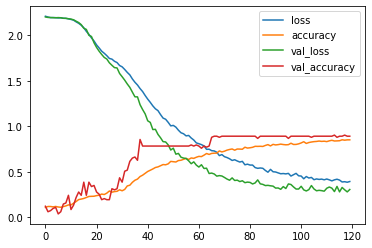

In [33]:
history = pd.DataFrame(model.history.history)
history.plot()

In [34]:
print("Classification accuracy:")
classification_dict = dict()
accuracy_list = list() 


for key in x_test_dict:
    x_test_numpy_temp = x_test_dict[key].drop([' TimeStamp (s)', 'Pose'], axis=1).values
    x_test_numpy_temp_3d = np.array(create_3d_array(x_test_numpy_temp))
    y_test_temp = np.array(create_2d_y_array(y_test_dict[key]))
    print(key)
    classify = model.evaluate(x_test_numpy_temp_3d, y_test_temp)
    # classifications = [i.argmax() for i in classify]
    # annotated_positions = y_test_dict[key].to_numpy()
    # correct_classifications = (classifications == annotated_positions).sum()
    # accuracy_list.append(round(correct_classifications/len(classifications)*100,2))
    # print(f"{key}: {accuracy_list[-1]}%")
    # classification_dict[key] = classifications

# print(f"Average accuracy: {round(sum(accuracy_list)/len(accuracy_list),2)}%")

Classification accuracy:
001
3/3 [==============================] - 0s 15ms/step - loss: 1.9188 - accuracy: 0.7561
002
3/3 [==============================] - 0s 13ms/step - loss: 1.3020 - accuracy: 0.6538
003
4/4 [==============================] - 0s 13ms/step - loss: 0.6034 - accuracy: 0.8400
004
3/3 [==============================] - 0s 14ms/step - loss: 0.3050 - accuracy: 0.8916
005
3/3 [==============================] - 0s 15ms/step - loss: 0.2664 - accuracy: 0.9778
006
3/3 [==============================] - 0s 12ms/step - loss: 0.2886 - accuracy: 0.9726
007
1/1 [==============================] - 0s 27ms/step - loss: 0.5939 - accuracy: 0.8571
008
1/1 [==============================] - 0s 30ms/step - loss: 1.7526 - accuracy: 0.6000
009
3/3 [==============================] - 0s 14ms/step - loss: 1.1395 - accuracy: 0.6750
010
3/3 [==============================] - 0s 13ms/step - loss: 1.9878 - accuracy: 0.5542


In [36]:
model.save("LSTM_2_sensorer_3.h5")